In [171]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, Lambda, Activation, Conv1D, MaxPooling1D, UpSampling1D, Reshape
from tensorflow.keras.models import Model
import random

2.4.1


In [352]:
window_size = 64
num_sensors = 3

In [353]:
n_filters = 3
filter_size = 3
pool_size = 2

In [354]:
participant_file_names = []
participants = []
for i in range(1,16):
    participant_file_names.append(np.genfromtxt('%i.csv'%(i), delimiter=','))
    participants.append(np.genfromtxt('%i.csv'%(i), delimiter=','))


In [355]:
participants_train = participants[:2]

In [356]:
import pandas as pd
from scipy.stats import mode
n=0
p = window_size
TIME_PERIODS = p
num_sensors = 3
Y = []
X = []
 
for j in range(1, num_sensors+1):
    x = []
    
    for k in range(len(participants_train)):
        x_participant = pd.DataFrame(participants_train[k][:,j])
        x_participant = pd.concat([x_participant.shift(i) for i in range(p)], axis=1).dropna()
        x.append(x_participant)
        
    
    x = np.vstack(x)
    x = np.expand_dims(x,2)
    
    X.append(x.T)

    
y = [] 
for k in range(len(participants_train)): 
    y_participant = pd.DataFrame(participants_train[k][:,4])
    y_participant = y_participant[p-1:]
    y.append(y_participant)
    
y = np.vstack(y)
y = y.flatten()

In [357]:
X = np.array(X).squeeze()
X=X.T
X.shape

(300376, 64, 3)

In [358]:
y_binary = to_categorical(y)

In [359]:
from sklearn.model_selection import train_test_split

In [360]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

In [361]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[:, :, 0] = scaler.fit_transform(X_train[:, :, 0])
X_train[:, :, 1] = scaler.fit_transform(X_train[:, :, 1])
X_train[:, :, 2] = scaler.fit_transform(X_train[:, :, 2])

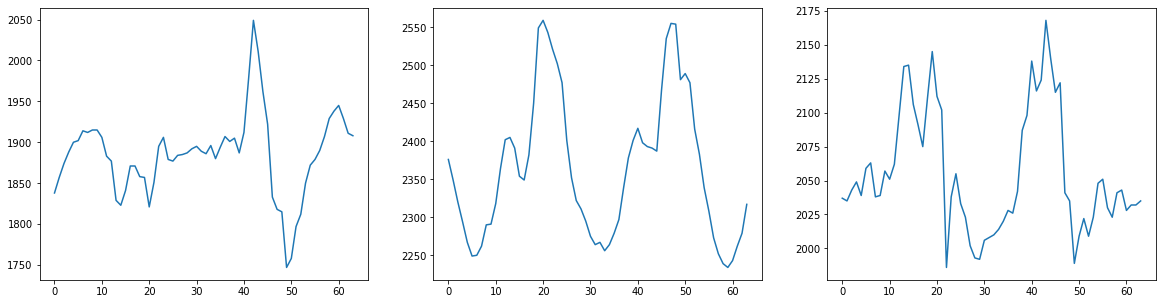

In [362]:
fig, ax = plt.subplots(1, num_sensors, figsize=[20, 5])
for i in range(len(ax)):
    ax[i].plot(X[50000, :, i])

In [364]:
tf.keras.backend.clear_session()

# Unsupervised learning and clustering of motifs from behavior time series using a Convolutional autoencoder
Here we will build off our convolutional network for supervised learning to do unsupervised learning with a convolutional autoencoder. 
Our goal is to view the clustering of the low-dimnensional latent space (last layer of encoded layer). The goal is to see if different windows of the time series cluster in the low-dimensional space


If we want to extract the weights on intermediate layers (latent space), then we will have to use the functional API for creating the model

https://github.com/tensorflow/tensorflow/issues/30955

# Keras Functional Models

In [365]:
from keras.layers import Input
encoder_input = Input(shape=(64, 3))

# Connecting Layers
The layers in the model are connected pairwise.

This is done by specifying where the input comes from when defining each new layer. A bracket notation is used, such that after the layer is created, the layer from which the input to the current layer comes from is specified.

Conv1D layers
https://keras.io/api/layers/convolution_layers/convolution1d/

# Creating the Model

After creating all of your model layers and connecting them together, you must define the model.

As with the Sequential API, the model is the thing you can summarize, fit, evaluate, and use to make predictions.

Keras provides a Model class that you can use to create a model from your created layers. It requires that you only specify the input and output layers. For example:

In [369]:
x = Conv1D(32,3, activation='relu', padding='same')(encoder_input)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(4,3, activation='relu', padding='same')(x1)
x3 = MaxPooling1D(2)(x2)
flat = Flatten()(x3)
encoded = Dense(2)(flat)
d1 = Dense(64)(encoded)
d2 = Reshape((16,4))(d1)
d3 = Conv1D(4,3, activation='relu', padding='same')(d2)
d4 = UpSampling1D(2)(d3)
d5 = Conv1D(8,3, activation='relu', padding='same')(d4)
d6 = UpSampling1D(2)(d5)
#d7 = UpSampling1D(2)(d6)
decoded = Conv1D(3,3,strides=1, activation='sigmoid', padding='same')(d6)
autoencoder= Model(encoder_input, decoded)

In [370]:
from keras.layers import Input
from keras.layers import Dense
model = Model(inputs=encoder_input, outputs=decoded)

In [371]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 3)]           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 64, 8)             80        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 8)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 4)             100       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 16, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130 

In [372]:
optimizer = "nadam"
loss = "mean_absolute_error"

autoencoder.compile(optimizer=optimizer, loss=loss)

In [373]:
autoencoder.fit(X_train, X_train, epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1643/1643 [==============================] - 26s 14ms/step - loss: 0.6536
Epoch 2/5
1643/1643 [==============================] - 23s 14ms/step - loss: 0.5230
Epoch 3/5
1643/1643 [==============================] - 18s 11ms/step - loss: 0.5180
Epoch 4/5
1643/1643 [==============================] - 18s 11ms/step - loss: 0.5162
Epoch 5/5
1643/1643 [==============================] - 22s 13ms/step - loss: 0.5154


In [374]:
from tensorflow.keras.models import Model
 
layer_index = 6
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=layer_index).output)



In [375]:
inds = np.arange(len(y))
random.shuffle(inds)

In [383]:
# get the data into the correct shape for the model

intermediate_output = []
for i in range(10000):
    x_predict = X[inds[i],:,:]
    x_predict = np.expand_dims(x_predict,0)
    intermediate_output.append(intermediate_layer_model.predict(x_predict).squeeze())

In [384]:
intermediate_output = np.array(intermediate_output)

In [385]:
from sklearn.manifold import TSNE

In [386]:
tsne = TSNE().fit_transform(intermediate_output)

No handles with labels found to put in legend.


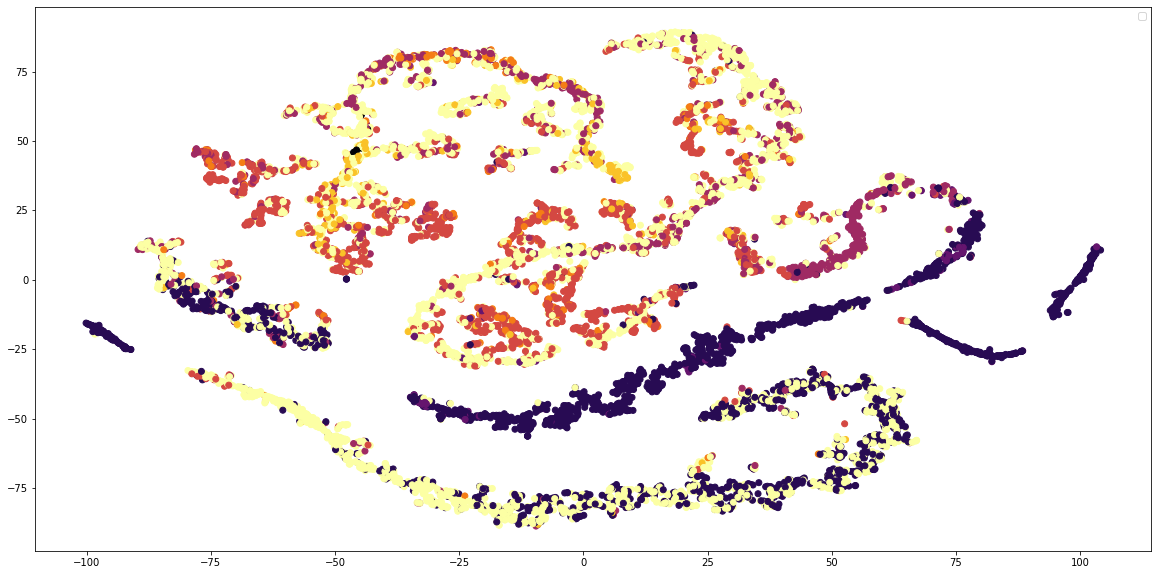

In [388]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(111)
ax.scatter(tsne[:, 0], tsne[:, 1],
             c=y[inds[:10000]], cmap='inferno')
ax.legend()

No handles with labels found to put in legend.


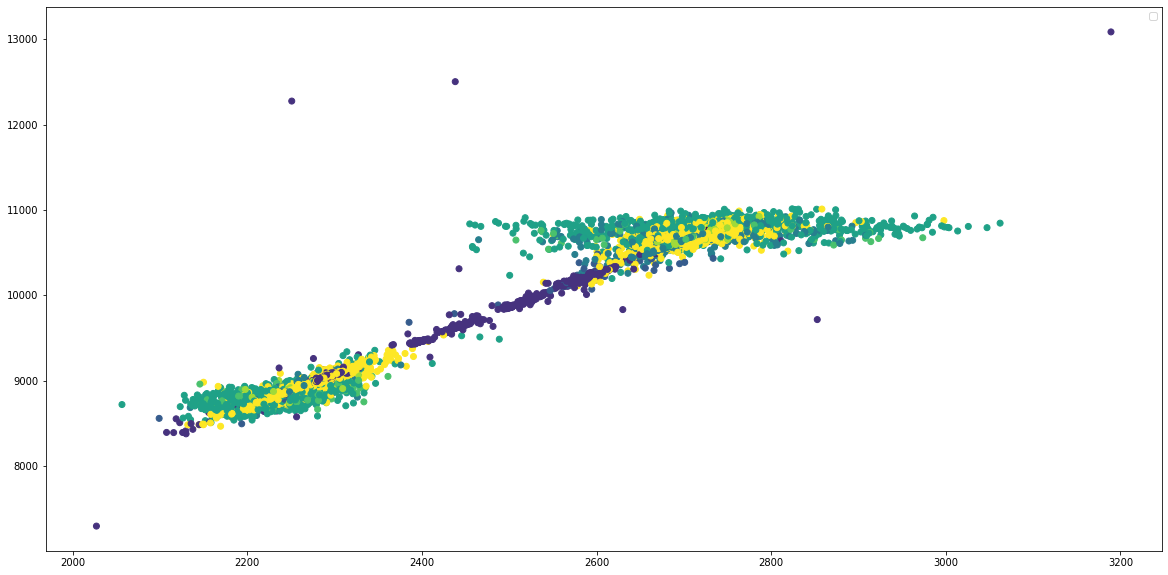

In [390]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(111)
ax.scatter(intermediate_output[:, 0], intermediate_output[:, 1],
             c=y[inds[:10000]], cmap='viridis')
ax.legend()

# perform K-means clustering on this latent space?

In [332]:
np.unique(y[inds[:5000]])

array([0., 1., 2., 3., 4., 5., 6., 7.])